## Описание проекта

Сети фитнес-центров «Культурист-датасаентист» требуется аналитическая модель поведения клиентов для разработки стратегии взаимодействия с ними и уменьшения оттока.
Для аналитики используем данные клиентских анкет с информацией по оттоку.

## Загрузка данных

In [10]:
# импортируем необходимые для работы библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
# загружаем файл с данными
data = pd.read_csv('/datasets/gym_churn.csv')

## Исследовательский анализ данных (EDA)

In [3]:
display(data.info())
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В базе 4000 записей без пропусков. Типы данных не требуют изменения для дальнейшей работы с данными.

In [4]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Первые пять столбцов, а также отток и групповые занятия, содержат категориальные данные (0 или 1), в остальных столбцах числовые значения. В данных не наблюдается каких-либо аномалий и выбросов.<br>
Доля клиентов с признаком оттока 1 составляет почти 27% (среднее значение столбца churn 0,2652).

In [5]:
# приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [6]:
# сгруппируем данные по признаку оттока с подсчетом средних значений
data_by_churn = data.groupby('churn').agg('mean')
data_by_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


В группе оттока наблюдаются существенно более низкие средние значения по признакам близости к фитнес-центру, партнерской программы, промо-акции, групповых занятий.
Также группа оттока имеет более низкие средние значения периода контракта, времени с момента первого обращения, возраста, дополнительных расходов, частоты посещений.
Практически не различаются в группах по признаку оттока пол и наличие телефона.

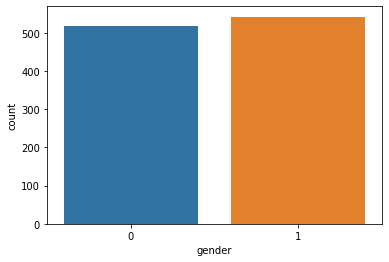

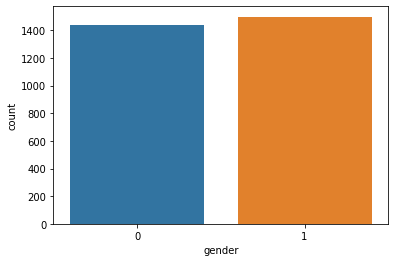

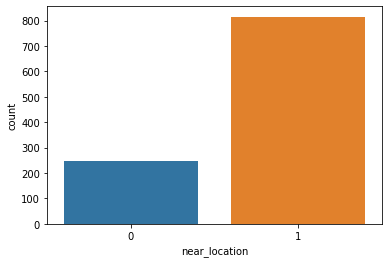

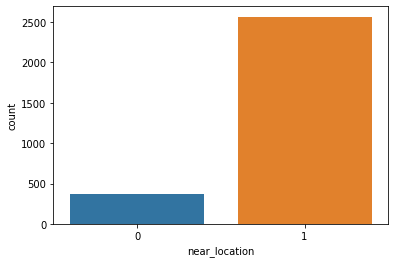

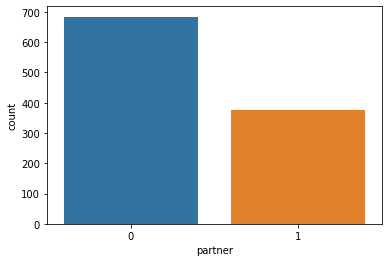

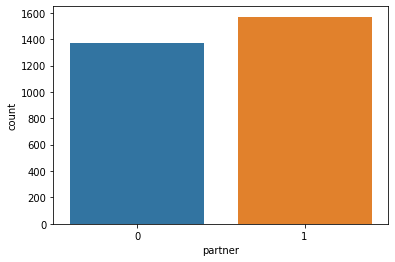

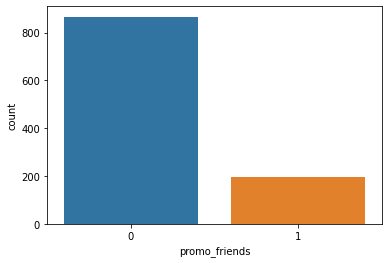

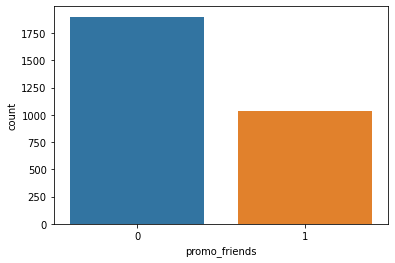

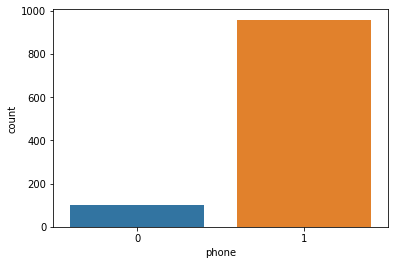

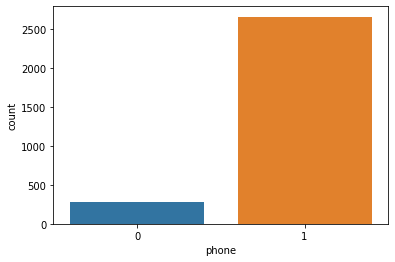

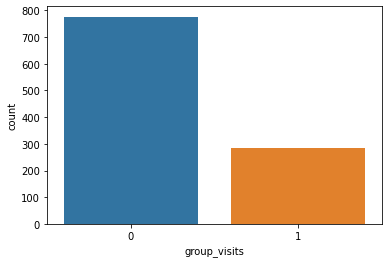

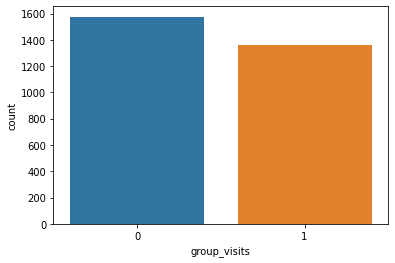

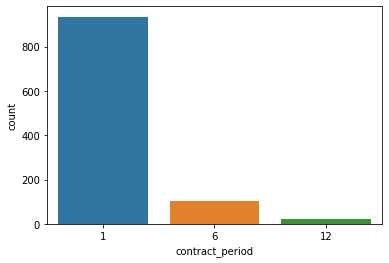

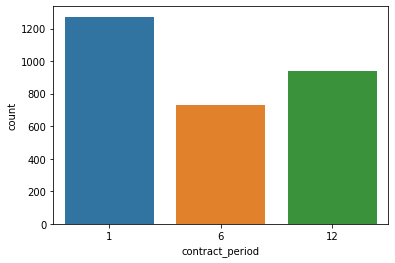

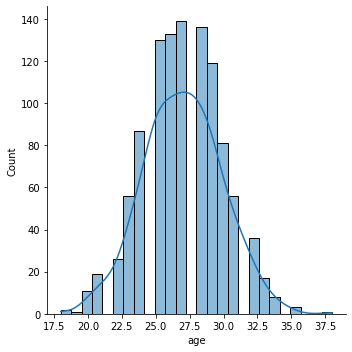

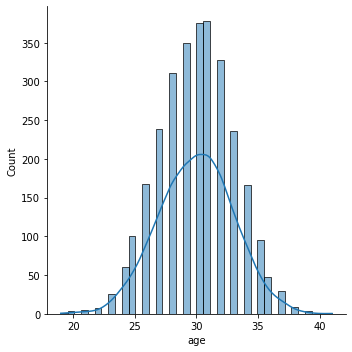

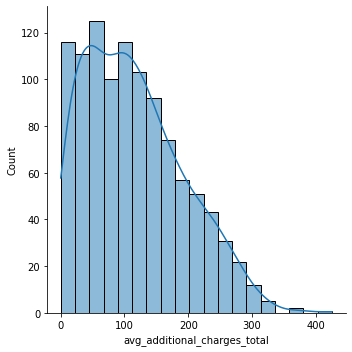

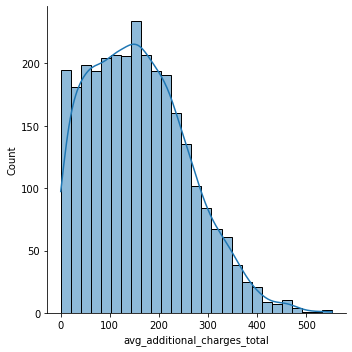

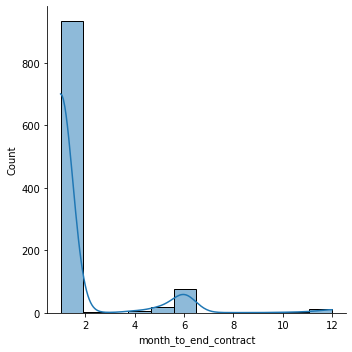

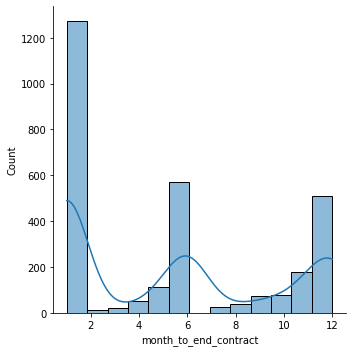

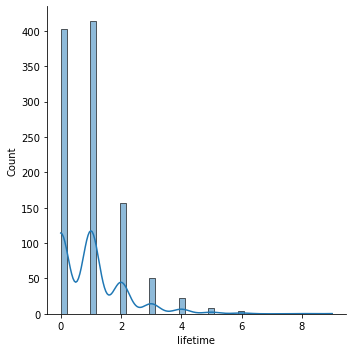

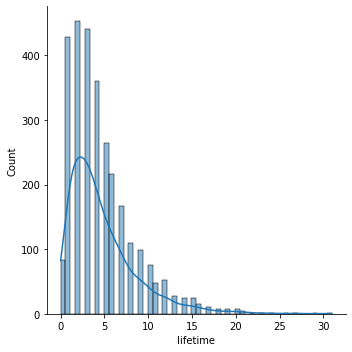

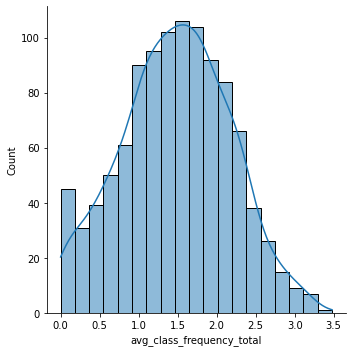

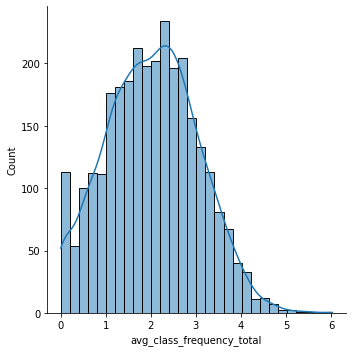

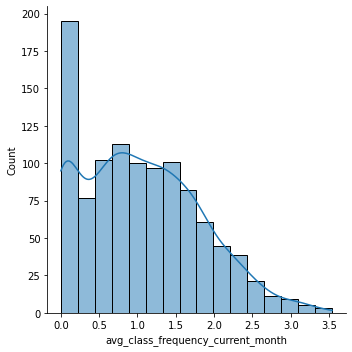

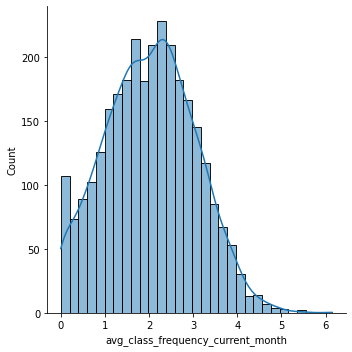

In [13]:
# построим распределение значений признаков в двух группах по признаку оттока
churn1 = data[data['churn'] == 1]
churn0 = data[data['churn'] == 0]

category = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
            'group_visits', 'contract_period']
value = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 
        'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

for col in category:
    sns.countplot(churn1[col])
    plt.show()
    sns.countplot(churn0[col])
    plt.show()
    
for col in value:
    sns.displot(churn1[col], kde=True)
    sns.displot(churn0[col], kde=True)
    plt.show()
    


По распределениям признаков можно наглядно наблюдать зависимости, выявленные при рассмотрении средних значений.

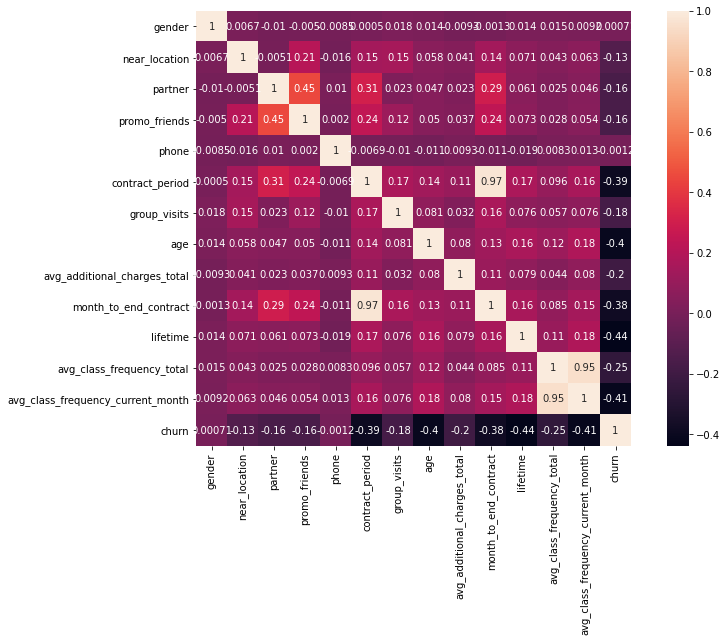

In [31]:
# построим тепловую карту матрицы корреляции данных
plt.figure(figsize=(13, 8))
mc = data.corr()
sns.heatmap(mc, annot=True, square=True)

plt.show()

На тепловой карте можно отметить следующие моменты:
- целевой признак оттока имеет наибольшую корреляцию с признаками времени с момента первого обращения, частотой занятий за последний месяц, возрастом, периодом контракта, причем все эти корреляции отрицательные (чем больше величина признака, тем меньше вероятность оттока);
- между собой сильно скоррелированы признаки: период контракта и месяцев до окончания контракта, частота занятий за последний месяц и всего, партнерская программа и промо-акция.<br>
Удалим мультиколлинеарные признаки для построения модели предсказания оттока.

In [32]:
data = data.drop('avg_class_frequency_total', axis=1)
data = data.drop('month_to_end_contract', axis=1)

## Модель прогнозирования оттока клиентов

Построим модели предсказания оттока клиентов на основании алгоритмов логистической регрессии и случайного леса.

In [35]:
# разделим данные на целевую переменную и признаки
X = data.drop('churn', axis=1)
y = data['churn']

# разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# стандартизируем признаки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# обучим модель логистической регрессии и предскажем целевую на тестовой выборке
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_st, y_train)
pred = model.predict(X_test_st)

# обучим модель случайного леса и предскажем целевую на тестовой выборке
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train_st, y_train)
rf_pred = rf_model.predict(X_test_st)


In [36]:
# посчитаем метрики для наших моделей
print('Accuracy LogisticRegression: {:.2f}, RandomForest: {:.2f}'.format(
    accuracy_score(y_test, pred), accuracy_score(y_test, rf_pred)))
print('Precision LogisticRegression: {:.2f}, RandomForest: {:.2f}'.format(
    precision_score(y_test, pred), precision_score(y_test, rf_pred)))
print('Recall LogisticRegression: {:.2f}, RandomForest: {:.2f}'.format(
    recall_score(y_test, pred), recall_score(y_test, rf_pred)))

Accuracy LogisticRegression: 0.92, RandomForest: 0.91
Precision LogisticRegression: 0.85, RandomForest: 0.85
Recall LogisticRegression: 0.84, RandomForest: 0.77


Для наших данных логистическая регрессия имеет лучшие метрики по сравнению со случайным лесом.<br>
Обе выбранные модели имеют достаточно высокую метрику по доле правильных ответов для всех значений категории оттока (92% и 91% соответственно).<br>
Метрика точности (доли правильных ответов для категории 1) у обеих моделей хуже и одинаковая - всего 85%.<br>
Еще ниже у обеих моделей метрика полноты (сколько объектов категории 1 смогла обнаружить модель) - 84% у логистической регресси и всего 77% у случайного леса.<br>
Для наших данных лучше использовать логистическую регресиию. Несмотря на не идеальные метрики, разработанную модель можно использовать для предсказания оттока с достаточно большой вероятностью.

## Кластеризация клиентов

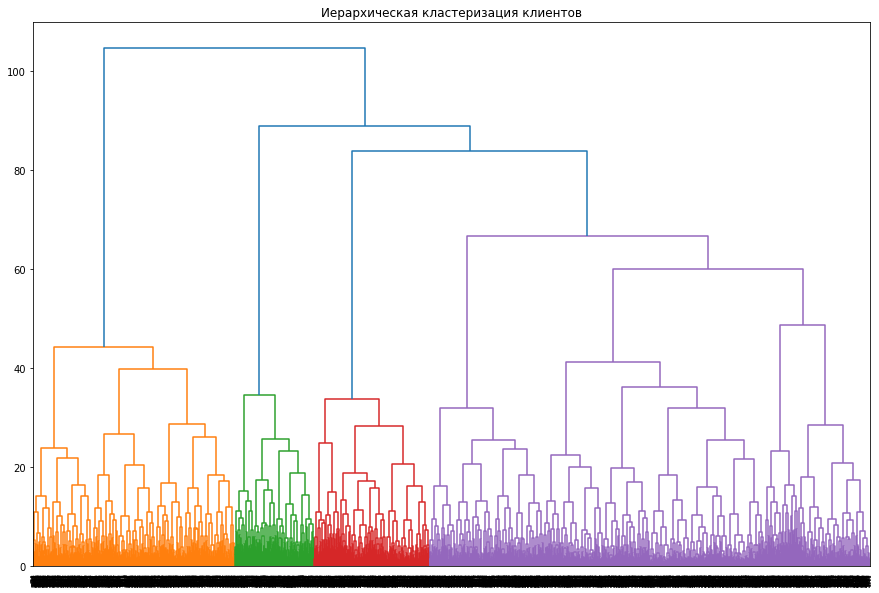

In [20]:
# стандартизируем вектор признаков целиком
X_sc = scaler.fit_transform(X)

# построим дендрограмму на основании иерархической кластеризации
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))   
dendrogram(linked, orientation='top') 
plt.title('Иерархическая кластеризация клиентов') 
plt.show()  

Оптимальное число кластеров на основании иерархической кластеризации - 4. Будем использовать именно это количество кластеров в дальнейшем.

In [23]:
# проведем кластеризацию клиентов по средним расстояниям между признаками для 4 кластеров
km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(X_sc)

# добавим столбец с номером кластера в основную таблицу
data['labels'] = labels

Проведенную кластеризацию можно использовать для формирования индивидуальных стратегий для каждого кластера.

In [25]:
# группируем данные по кластерам и вычисляем средние для целевой переменной и признаков
data_by_label = data.groupby('labels').agg('mean')
data_by_label

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
labels,,,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525,1.805274,2.235294,1.204610,0.951590,0.559838
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764,2.239357,4.704825,2.724796,2.711132,0.092715
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032,9.768089,4.730056,1.983884,1.975592,0.029685


Средний отток максимален в кластере 1, минимален в кластере 3. Кластер 2 также имеет довольно высокую среднюю по оттоку.<br>
В кластере 1 мы наблюдаем самые низкие средние показатели частоты занятий за последний месяц и всего, времени с момента первого посещения, месяцев до окончания контракта, дополнительных расходов, групповых визитов. Также в этом кластере ниже средний возраст.

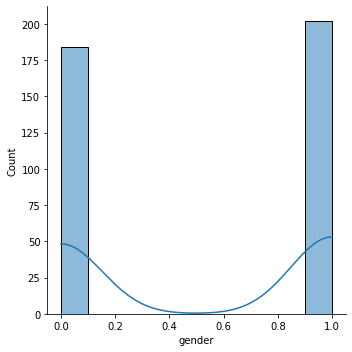

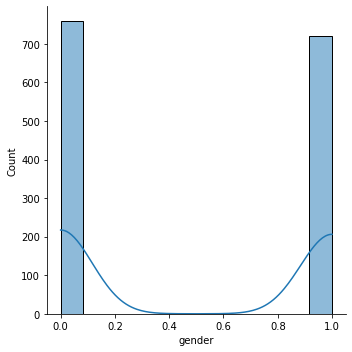

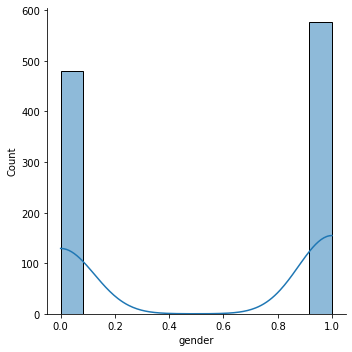

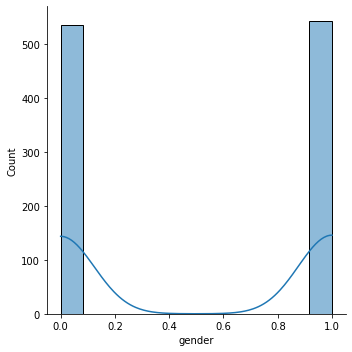

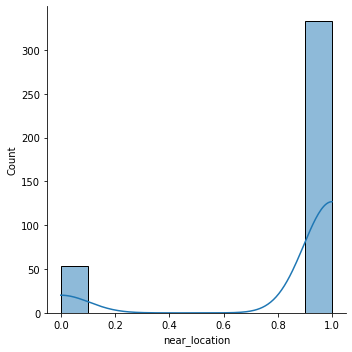

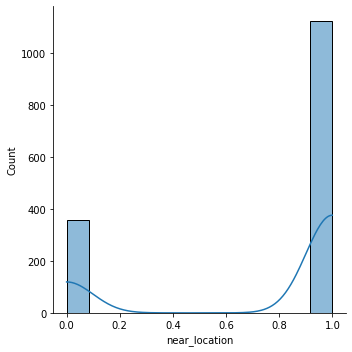

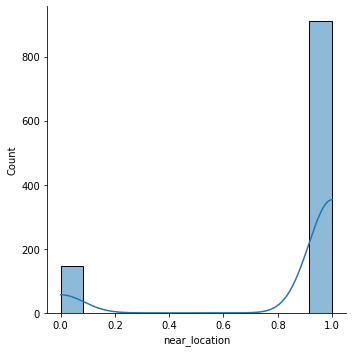

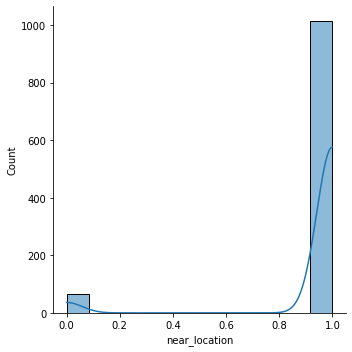

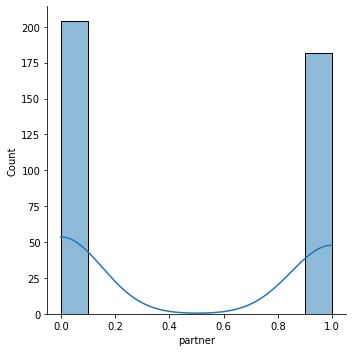

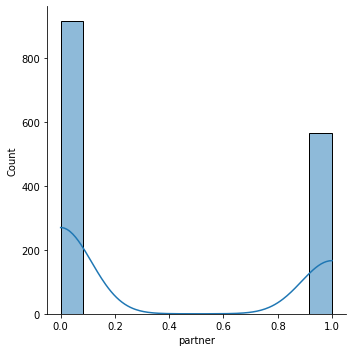

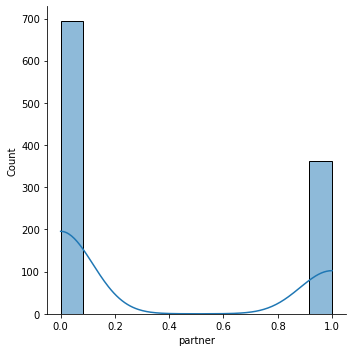

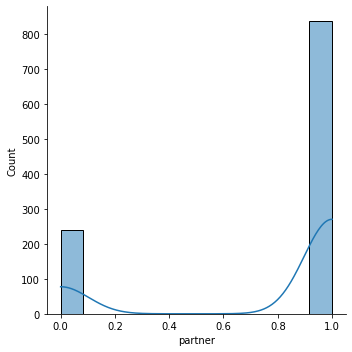

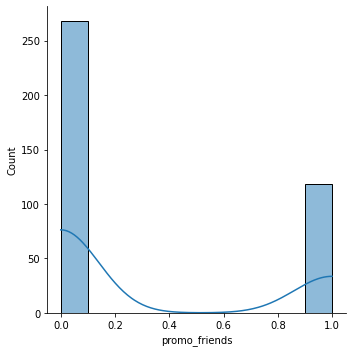

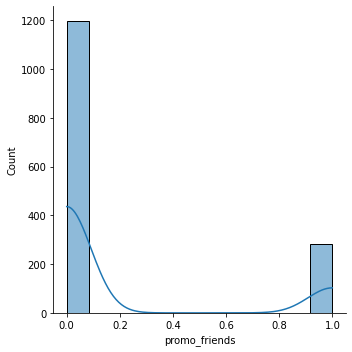

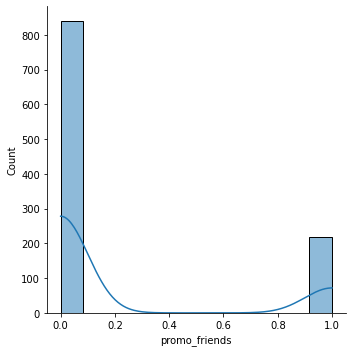

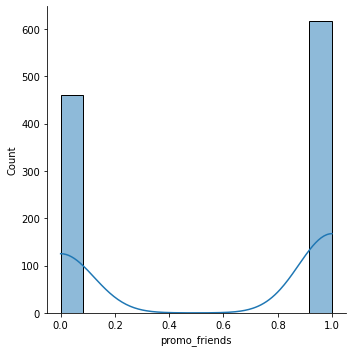

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


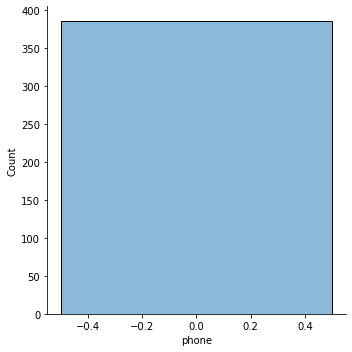

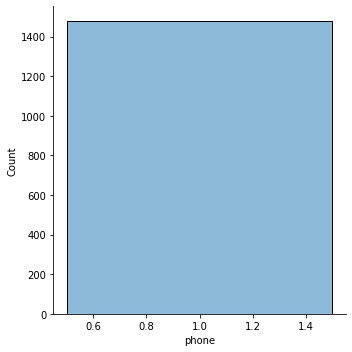

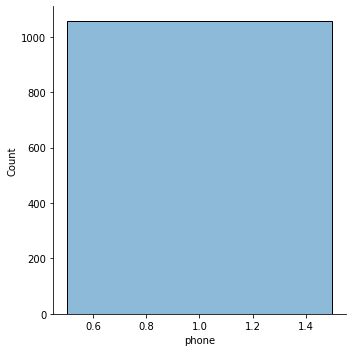

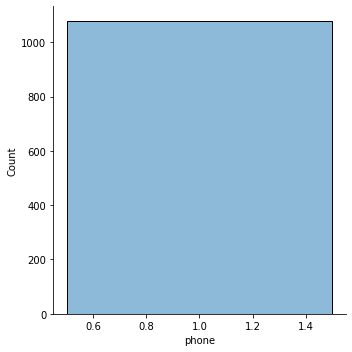

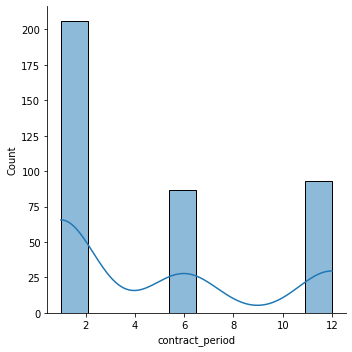

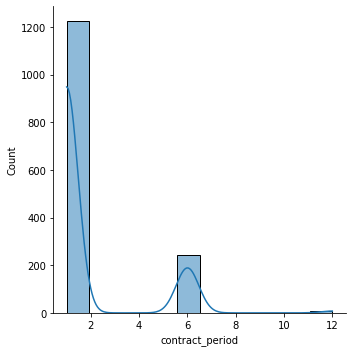

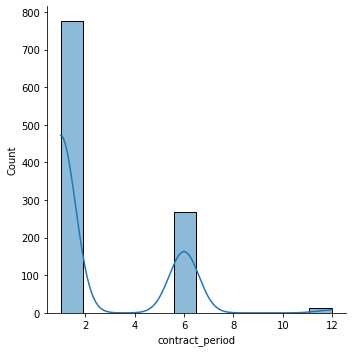

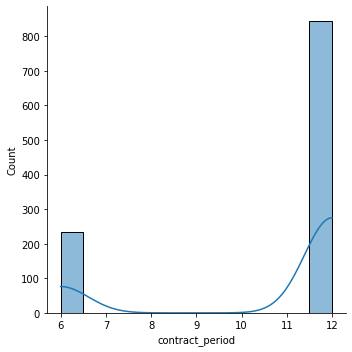

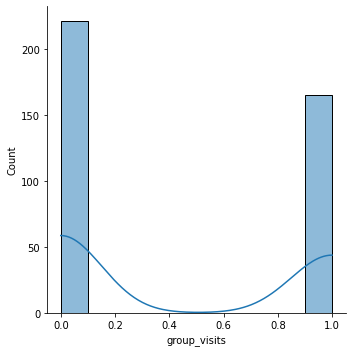

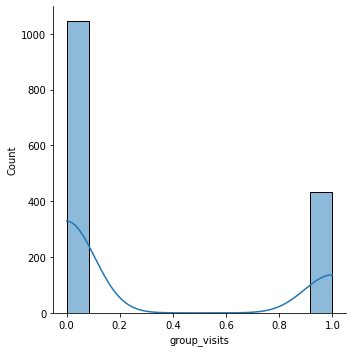

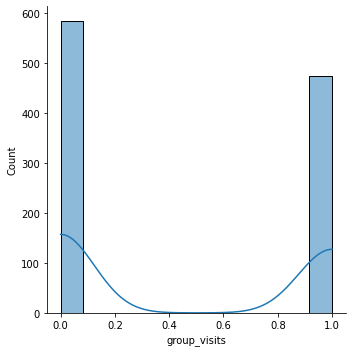

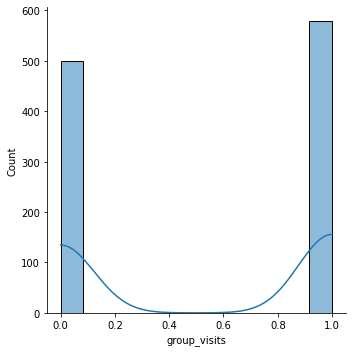

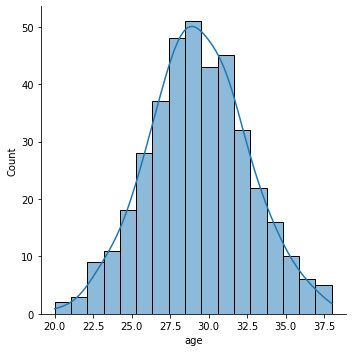

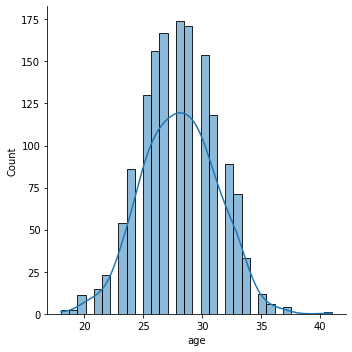

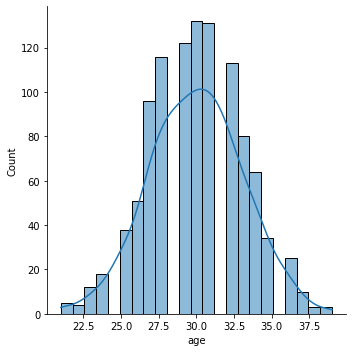

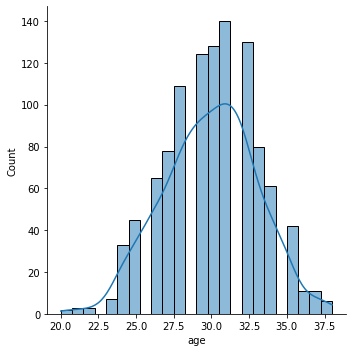

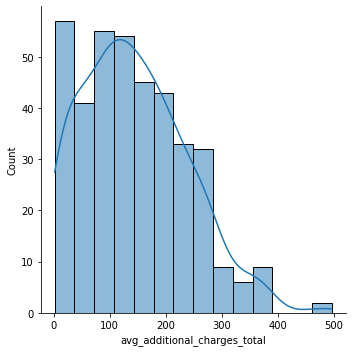

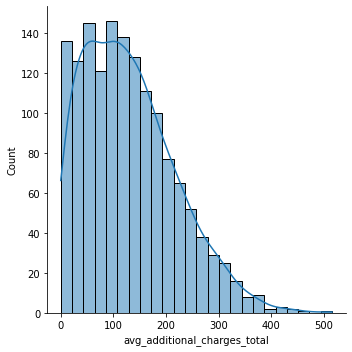

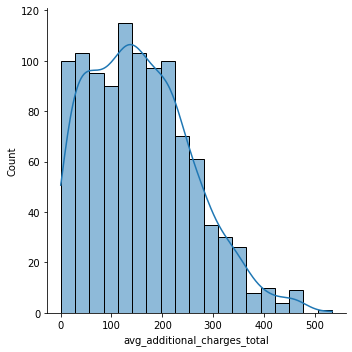

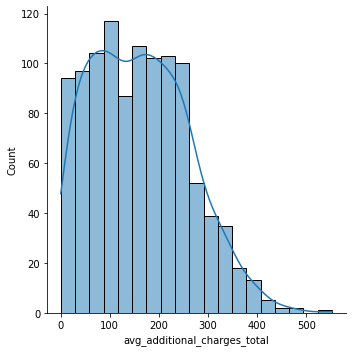

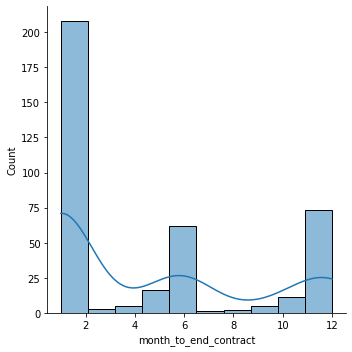

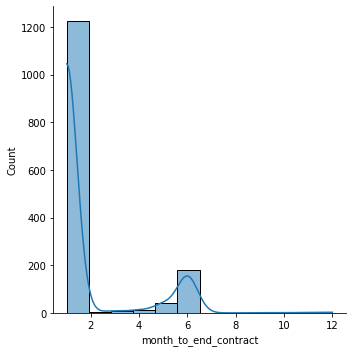

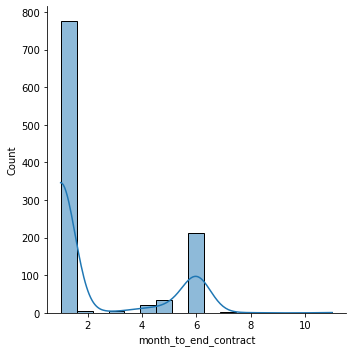

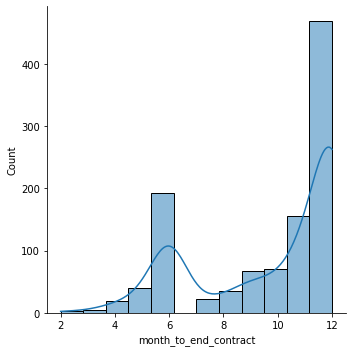

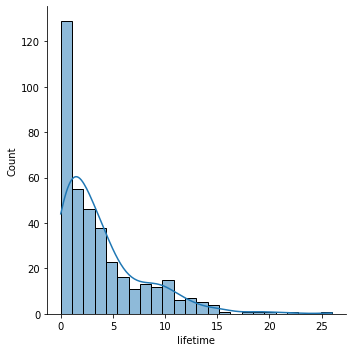

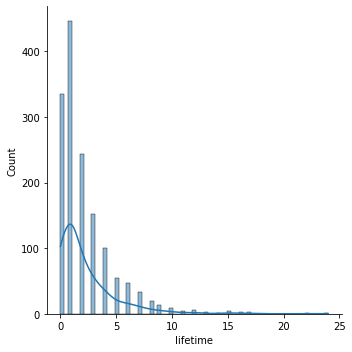

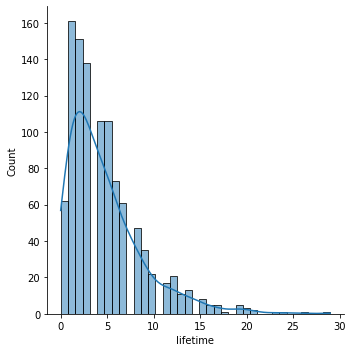

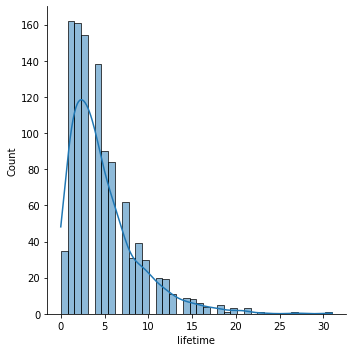

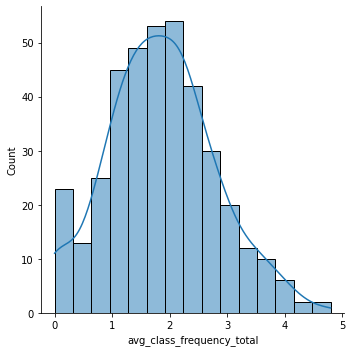

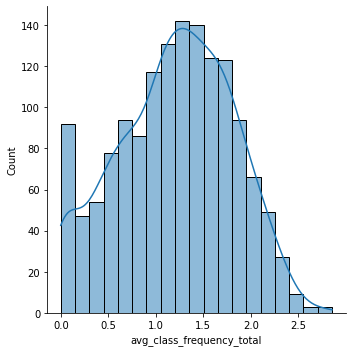

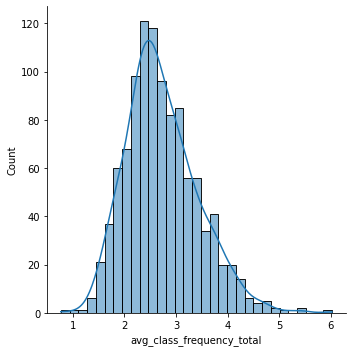

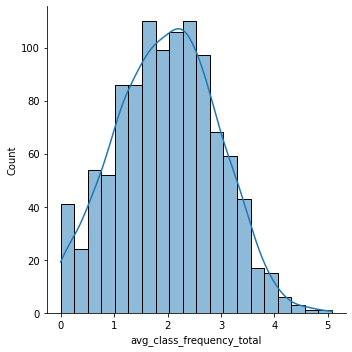

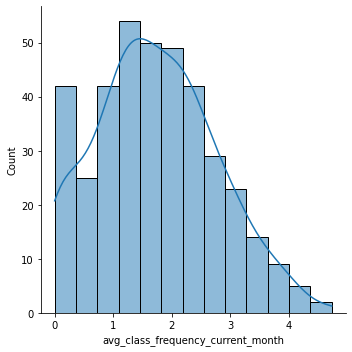

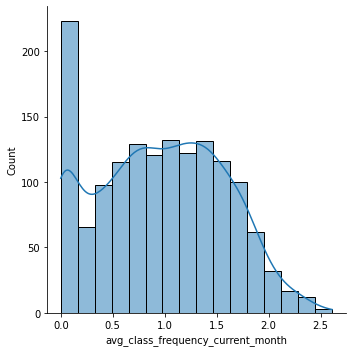

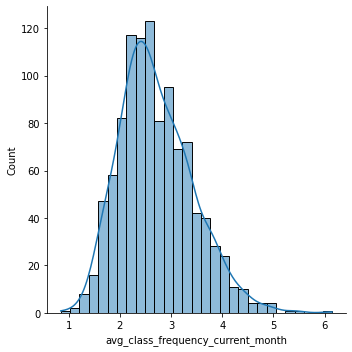

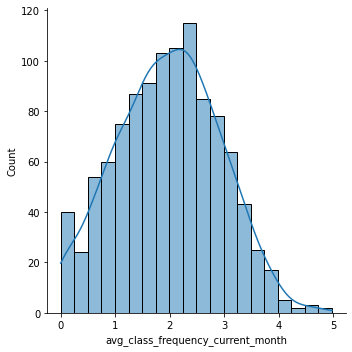

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


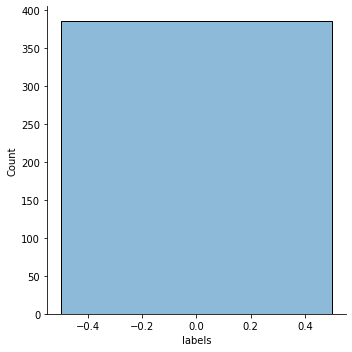

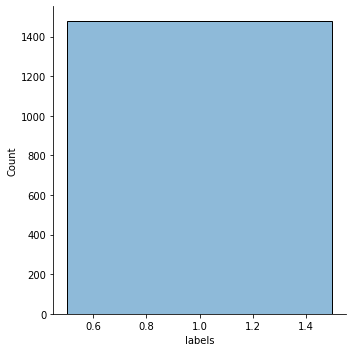

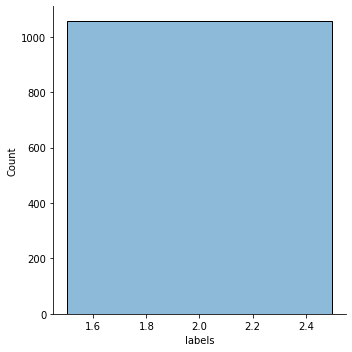

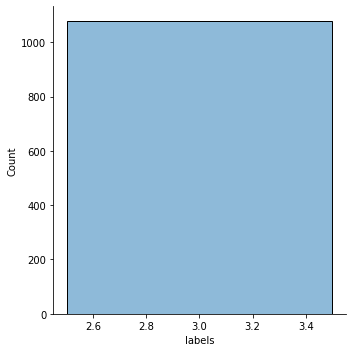

In [26]:
# построим распределение признаков в каждом кластере
label0 = data[data['labels'] == 0]
label1 = data[data['labels'] == 1]
label2 = data[data['labels'] == 2]
label3 = data[data['labels'] == 3]
for col in label0.drop('churn', axis=1).columns:
    sns.displot(label0[col], kde=True)
    sns.displot(label1[col], kde=True)
    sns.displot(label2[col], kde=True)
    sns.displot(label3[col], kde=True)
    plt.show()

In [35]:
# выведем отдельно долю оттока в каждом кластере
data_by_label_churn = data.groupby('labels').agg({'churn': ['mean']})
data_by_label_churn

,churn
,mean
labels,
0,0.266839
1,0.559838
2,0.092715
3,0.029685


Наибольшую долю оттока имеет кластер 1. Лучший по оттоку кластер 3.

## Выводы и рекомендации

На основании данных анкет клиентов разработаны модели, позволяющие прогнозировать вероятность оттока клиентов в будущем.<br>
Более других на вероятность оттока влияют признаки времени с момента первого обращения, частотой занятий за последний месяц, возрастом, периодом контракта, а также участие в групповых занятиях, партнерских программах и промо-акции. Чем больше значения этих признаков, тем вероятность оттока меньше.<br><br>
По разнице признаков все клиенты разбиты на 4 группы/кластера.<br>
Кластер 3, лучший по показателю оттока, характеризуют бОльшие доли проживающих/работающих рядом с фитнес-центром, участвующих в партнерской программе и промо-акции, групповых занятиях. Клиенты из этого кластера имеют более длинные контракты, чаще занимаются и больше тратят на дополнительные услуги.<br>
Худший по показателю оттока кластер 1 имеет низкие показатели участия в партнерской программе и промо-акции, групповых занятиях, короткие контракты. Клиенты этого кластера меньше тратят на дополнительные услуги и меньше занимаются.<br><br>
Исходя из проведенного анализа можно предложить следующие рекомендации для снижения оттока:<br><br>
Для новых клиентов:
- при продаже абонементов делать упор на большие сроки контракта;<br>
- активнее привлекать клиентов по партнерским программам и промо-акциям "приведи друга";<br>
- привлекать больше клиентов из района размещения фитнес-центра.<br><br>
Для существующих клиентов:<br>
- разработать специальную маркетинговую программу для кластера 1, чтобы увеличить показатели по ключевым признакам и уменьшить отток;
- адресно работать с клиентами, для которых моделью прогнозируется отток - предлагать групповые занятия, участие в промо-акции, мотивировать на увеличение частоты занятий.


